# Abordagem 1: MediaPipe + CNN Simples (TensorFlow)


In [32]:
!pip install mediapipe opencv-python


In [33]:
!wget https://github.com/chenyijia1997/Face-datasets/raw/main/faces94.zip --no-check-certificate || \


--2025-08-03 21:19:52--  https://github.com/chenyijia1997/Face-datasets/raw/main/faces94.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chenyijia1997/Face-datasets/main/faces94.zip [following]
--2025-08-03 21:19:52--  https://raw.githubusercontent.com/chenyijia1997/Face-datasets/main/faces94.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18845407 (18M) [application/zip]
Saving to: ‘faces94.zip.1’

faces94.zip.1       100%[===================>]  17.97M  --.-KB/s    in 0.1s    

2025-08-03 21:19:52 (143 MB/s) - ‘faces94.zip.1’ saved [18845407/18845407]



In [34]:
import zipfile
import os

os.makedirs('faces94', exist_ok=True)

with zipfile.ZipFile('faces94.zip', 'r') as zip_ref:
    zip_ref.extractall('faces94')

print(os.listdir('faces94/faces94'))

['female', 'malestaff', 'male']


In [35]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

input_dir = 'faces94/faces94'
output_dir = 'faces_cropped'
os.makedirs(output_dir, exist_ok=True)

for category in os.listdir(input_dir):  # male, female, staff
    category_path = os.path.join(input_dir, category)
    for person in os.listdir(category_path):
        person_dir = os.path.join(category_path, person)
        output_person_dir = os.path.join(output_dir, person)
        os.makedirs(output_person_dir, exist_ok=True)

        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_detection.process(image_rgb)

            if results.detections:
                for i, detection in enumerate(results.detections):
                    bbox = detection.location_data.relative_bounding_box
                    ih, iw, _ = image.shape
                    x1 = int(bbox.xmin * iw)
                    y1 = int(bbox.ymin * ih)
                    x2 = int((bbox.xmin + bbox.width) * iw)
                    y2 = int((bbox.ymin + bbox.height) * ih)

                    face_img = image[y1:y2, x1:x2]
                    if face_img.size == 0:
                        continue
                    face_img = cv2.resize(face_img, (224, 224))

                    save_path = os.path.join(output_person_dir, f'{img_name}')
                    cv2.imwrite(save_path, face_img)

In [36]:
import tensorflow as tf

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'faces_cropped',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'faces_cropped',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3058 files belonging to 153 classes.
Using 2447 files for training.
Found 3058 files belonging to 153 classes.
Using 611 files for validation.
Classes: ['9326871', '9332898', '9336923', '9338446', '9338454', '9338462', '9338489', '9338497', '9338519', '9338527', '9338535', '9338543', '9414649', '9416994', 'admars', 'ahodki', 'ajflem', 'ajones', 'ajsega', 'akatsi', 'ambarw', 'anonym', 'anonym1', 'anonym2', 'anpage', 'asamma', 'asewil', 'asheal', 'astefa', 'bplyce', 'cchris', 'ccjame', 'cferdo', 'cgboyc', 'cjcarr', 'cjdenn', 'cjsake', 'cmkirk', 'csanch', 'cshubb', 'cwang', 'cwchoi', 'dagran', 'dakram', 'dcbowe', 'dioann', 'djbirc', 'djhugh', 'djmart', 'dmwest', 'doraj', 'drbost', 'ekavaz', 'elduns', 'fordj', 'gdhatc', 'ggeorg', 'ggrego', 'gjhero', 'gjnorm', 'gmwate', 'gotone', 'gpapaz', 'gpsmit', 'gsreas', 'hartb', 'hensm', 'ieorf', 'irdrew', 'jabins', 'jagrif', 'jcarte', 'jdbenm', 'jgloma', 'jlemon', 'jmedin', 'jrtobi', 'kaatki', 'kaknig', 'kdjone', 'khchan', 'khughe', 'kjwith', '

In [37]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.0039 - loss: 5.0303 - val_accuracy: 0.0000e+00 - val_loss: 4.9937
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.0091 - loss: 4.8529 - val_accuracy: 0.0147 - val_loss: 4.4577
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.0310 - loss: 4.2443 - val_accuracy: 0.0507 - val_loss: 3.9869
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.0848 - loss: 3.7199 - val_accuracy: 0.1113 - val_loss: 3.4335
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.1591 - loss: 3.1897 - val_accuracy: 0.1686 - val_loss: 3.0454
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.2211 - loss: 2.7157 - val_accuracy: 0.2700 - val_loss: 2.6990
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.2974 - loss: 2.3667 - val_accuracy: 0.2602 - val_loss: 2.6220
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.3263 - loss: 2.2022 - val_accuracy: 0.3552 - val_loss

In [38]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        for detection in results.detections:
            bbox = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            x1 = int(bbox.xmin * iw)
            y1 = int(bbox.ymin * ih)
            x2 = int((bbox.xmin + bbox.width) * iw)
            y2 = int((bbox.ymin + bbox.height) * ih)

            face_img = frame[y1:y2, x1:x2]
            if face_img.size == 0:
                continue
            face_img = cv2.resize(face_img, (img_height, img_width))
            face_array = tf.expand_dims(face_img, axis=0) / 255.0

            predictions = model.predict(face_array)
            predicted_class = class_names[tf.argmax(predictions[0])]

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, predicted_class, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2.imshow('Face Recognition', frame)
    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


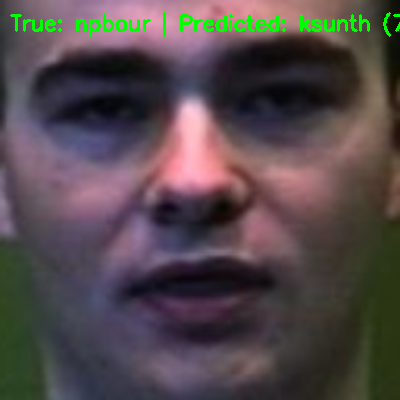

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


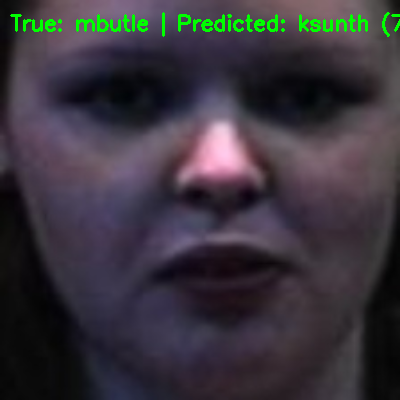

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


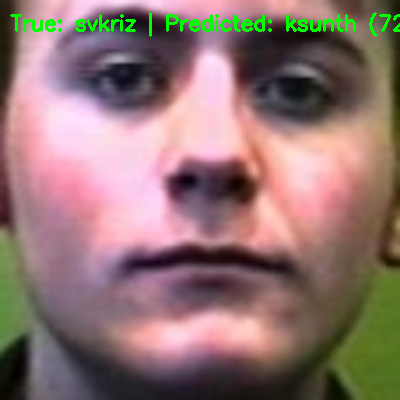

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


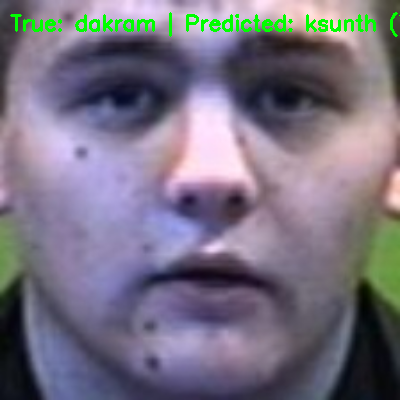

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


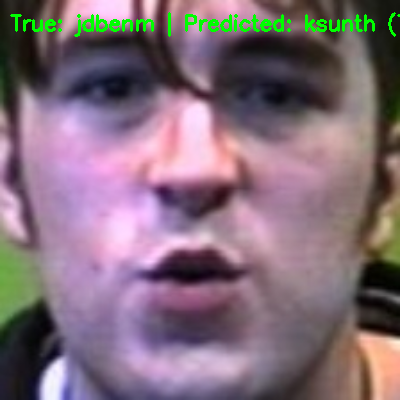

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


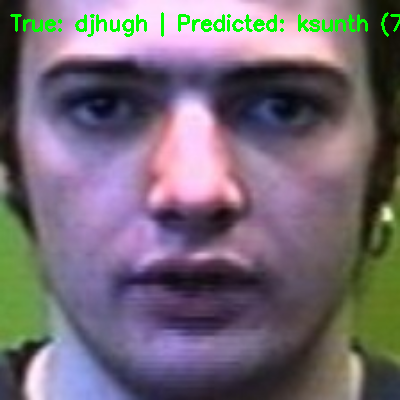

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


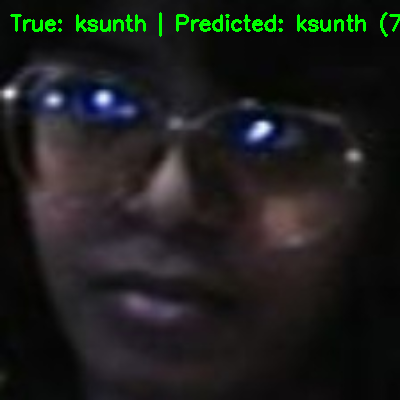

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


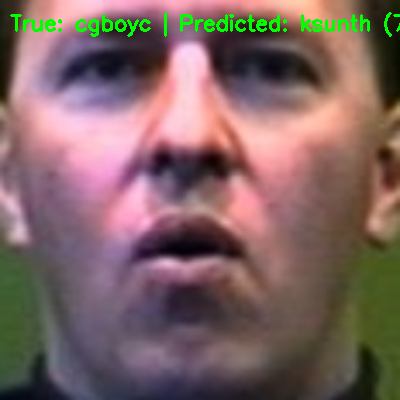

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


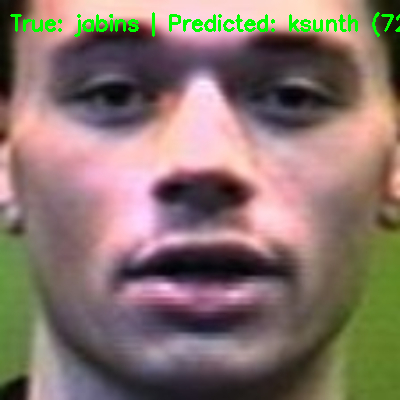

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


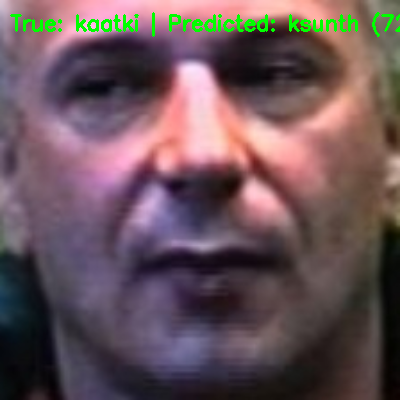

Acertos: 1/10 - Acurácia: 10.00%


In [42]:
import cv2
import numpy as np
import tensorflow as tf
import random
import os
from google.colab.patches import cv2_imshow
import time

# Selecionar 10 imagens aleatórias do dataset
sample_images = []
for _ in range(10):
    person = random.choice(class_names)
    person_dir = os.path.join('faces_cropped', person)
    img_file = random.choice(os.listdir(person_dir))
    sample_images.append(os.path.join(person_dir, img_file))

# Inicializar contador de acertos
correct_predictions = 0
total_samples = len(sample_images)

# Loop de Exibição (cv2_imshow)
for img_path in sample_images:
    # Carregar imagem
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    img_input = np.expand_dims(img_resized, axis=0) / 255.0

    # Predição
    predictions = model.predict(img_input)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index] * 100  # Convertendo para %

    # True Label
    true_label = img_path.split('/')[-2]

    # Validar Acerto
    if predicted_class == true_label:
        correct_predictions += 1

    # Texto com True Label, Predição e Confiança
    text = f'True: {true_label} | Predicted: {predicted_class} ({confidence:.2f}%)'

    # Exibir Imagem
    img_display = cv2.resize(img, (400, 400))
    cv2.putText(img_display, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2_imshow(img_display)

    # Espera 1 segundo antes de mostrar a próxima
    time.sleep(1)

cv2.destroyAllWindows()

# Mostrar Resultado Final
accuracy = (correct_predictions / total_samples) * 100
print(f'Acertos: {correct_predictions}/{total_samples} - Acurácia: {accuracy:.2f}%')


# Abordagem 2: FaceNet Embeddings + KNN

In [7]:
!pip install facenet-pytorch

import os
import torch
import numpy as np
import cv2
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.neighbors import KNeighborsClassifier
from google.colab.patches import cv2_imshow
import time
import random


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=20, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [9]:
faces_dir = 'faces_cropped'
class_names = os.listdir(faces_dir)

In [10]:
embeddings = []
labels = []

for person in class_names:
    person_dir = os.path.join(faces_dir, person)
    for img_file in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_file)

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        face = mtcnn(img_rgb)
        if face is not None:
            face_embedding = resnet(face.unsqueeze(0).to(device))
            embeddings.append(face_embedding.detach().cpu().numpy())
            labels.append(person)

embeddings = np.vstack(embeddings)
labels = np.array(labels)
print(f"Total de embeddings extraídos: {embeddings.shape[0]}")

Total de embeddings extraídos: 3006


In [11]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(embeddings, labels)
print("KNN treinado.")

KNN treinado.


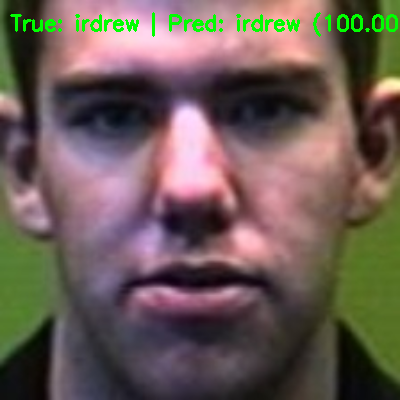

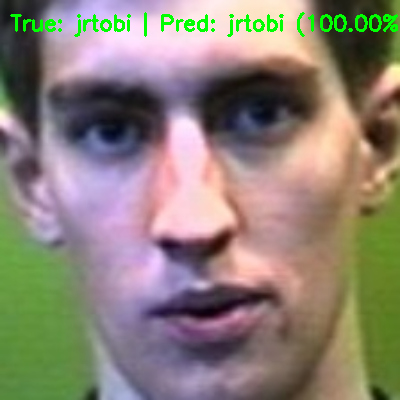

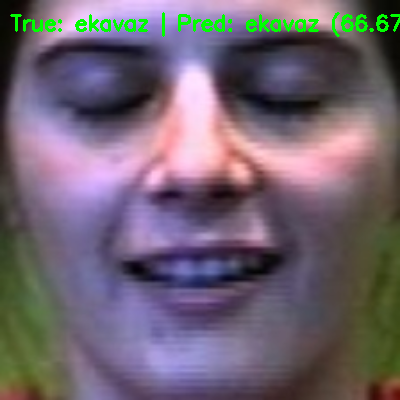

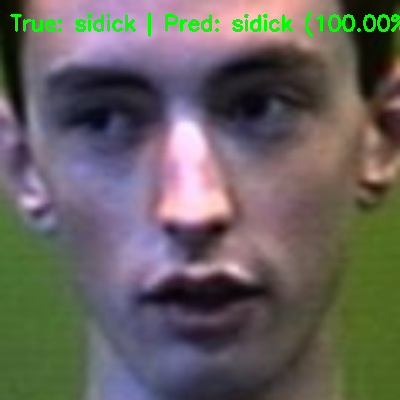

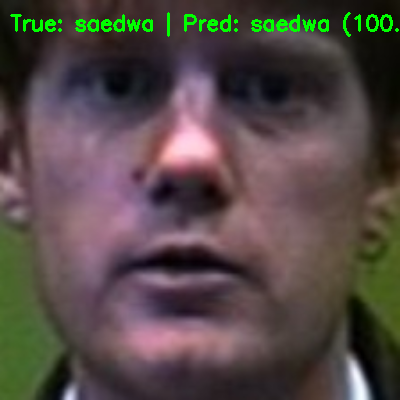

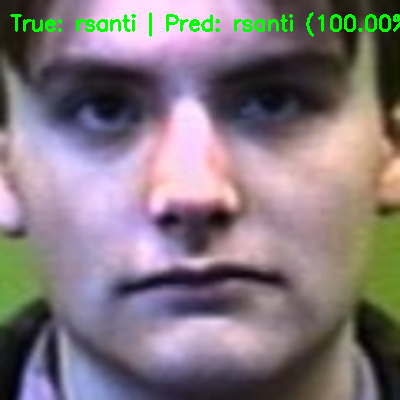

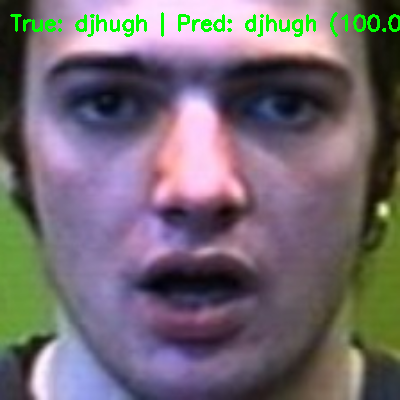

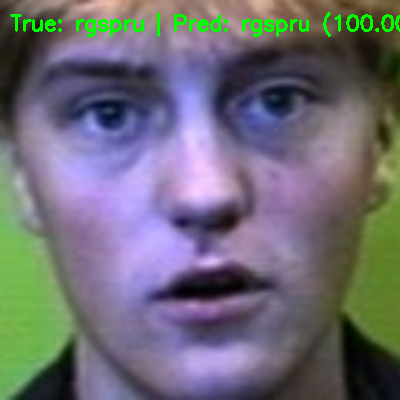

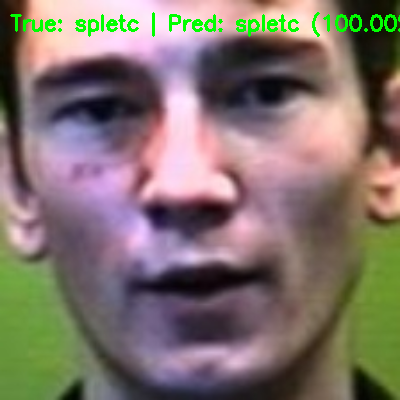

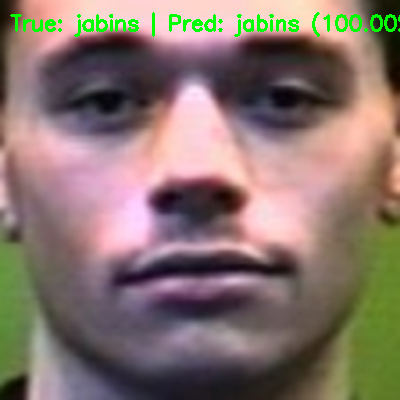

Acertos: 10/10 - Acurácia: 100%


In [12]:
sample_images = []
for _ in range(10):
    person = random.choice(class_names)
    person_dir = os.path.join(faces_dir, person)
    img_file = random.choice(os.listdir(person_dir))
    sample_images.append(os.path.join(person_dir, img_file))

correct_predictions = 0

for img_path in sample_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    face = mtcnn(img_rgb)
    if face is not None:
        face_embedding = resnet(face.unsqueeze(0).to(device)).detach().cpu().numpy()

        pred_label = knn.predict(face_embedding)[0]
        pred_proba = knn.predict_proba(face_embedding)
        confidence = np.max(pred_proba) * 100

        true_label = img_path.split('/')[-2]

        if pred_label == true_label:
            correct_predictions += 1

        text = f'True: {true_label} | Pred: {pred_label} ({confidence:.2f}%)'
        img_display = cv2.resize(img, (400, 400))
        cv2.putText(img_display, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2_imshow(img_display)
        time.sleep(1)

print(f"Acertos: {correct_predictions}/10 - Acurácia: {correct_predictions * 10}%")